<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/HT_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn seaborn

In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input  # Correct import for preprocess_input

# 🧠 Classes
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {cls: i for i, cls in enumerate(classes)}

# 📂 Image Loading
IMG_SIZE = 160  # Reduced image size for faster processing
X, y = [], []
DATASET_PATH = "OvarianCancer"

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    if not os.path.exists(cls_path): continue
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)  # Correct preprocessing function for each image
        X.append(img)
        y.append(class_mapping[cls])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))

# 🧪 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Dataset loaded: {len(X)} images")

# 🔁 Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced rotation range
    zoom_range=0.2,  # Reduced zoom range
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
train_generator = datagen.flow(X_train, y_train, batch_size=16)  # Reduced batch size

# 🧠 Build Model with EfficientNetV2S
base_model = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Unfreeze a smaller number of layers for faster training
for layer in base_model.layers[-5:]:  # Unfreeze the last 5 layers instead of 10
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

# 🧪 Compile with mixed precision and smaller learning rate
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)  # Use set_global_policy instead of set_policy

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 🛑 Early stopping
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1)

# 🚀 Train
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop]
)


✅ Dataset loaded: 497 images


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 297s 8s/step - accuracy: 0.2000 - loss: 3.3781 - val_accuracy: 0.3400 - val_loss: 2.2619
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.3538 - loss: 2.7039 - val_accuracy: 0.5400 - val_loss: 2.0880
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 201s 7s/step - accuracy: 0.3783 - loss: 2.4385 - val_accuracy: 0.5900 - val_loss: 1.9622
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 186s 7s/step - accuracy: 0.5804 - loss: 1.9370 - val_accuracy: 0.6800 - val_loss: 1.8278
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.5779 - loss: 1.8950 - val_accuracy: 0.6800 - val_loss: 1.7294
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.6787 - loss: 1.6869 - val_accuracy: 0.7400 - val_loss: 1.6417
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 207s 7s/step - accuracy: 0.7231 - loss: 1.6065 - val_accuracy: 0.6800 - val_loss: 1.5501
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.7747 - loss: 1.4859 - val_accuracy: 0.7300 - v

In [12]:
# 🎯 Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Final Test Accuracy: {acc:.4f}")
print(f"✅ Final Test Loss: {loss:.4f}")

# 💾 Save model
model.save("efficientnetv2_ovarian_best.keras")
print("✅ Model saved as 'efficientnetv2_ovarian_best.keras'")


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8329 - loss: 1.3400
✅ Final Test Accuracy: 0.8400
✅ Final Test Loss: 1.3176
✅ Model saved as 'efficientnetv2_ovarian_best.keras'


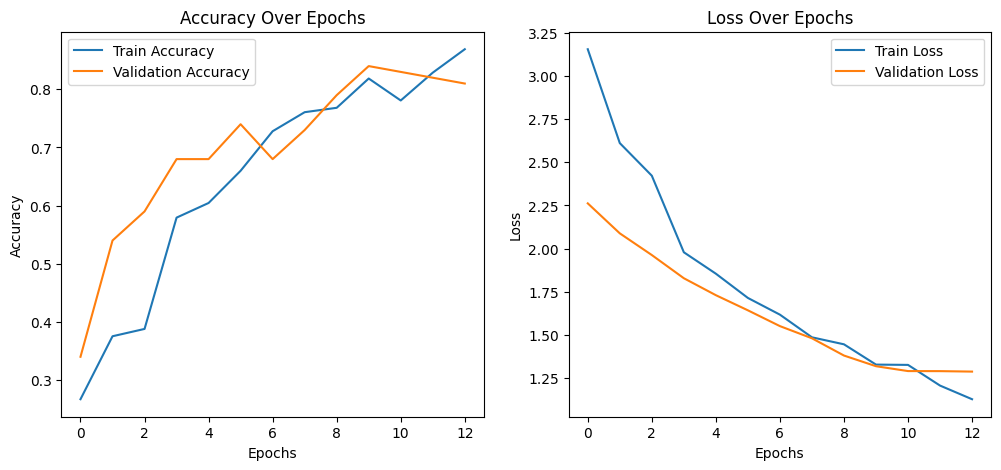

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()